# Data preparation for the Energy-based diffusion model

Compared to the similarity-kernel based generation, the energy-based diffusion model is specifically trained to generate molecules. Thus, we have to ensure a proper training/test split. To make this more challenging we first cluster the molecules, and leave some clusters out for testing.

In [55]:
import ase
import ase.io as aio
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolDescriptors

import matplotlib.pyplot as plt

In [3]:
all_qm9 = aio.read("/home/re344/rds/hpc-work/data/qm9_full_data.xyz", index=":", format="extxyz")

In [4]:
from moldiff.analysis import get_rdkit_mol

In [6]:
mols = []
ids = []
for i, atoms in enumerate(all_qm9):
    mol, error = get_rdkit_mol(atoms)
    if mol is None:
        print(f"Failed to convert atoms to rdkit mol: {error}")
    else:
        mols.append(mol)
        ids.append(i)

Failed to convert atoms to rdkit mol: Valence of atom 5 is 5, which is larger than the allowed maximum, 4
Failed to convert atoms to rdkit mol: Final molecular charge does not match input; could not find valid bond ordering
Failed to convert atoms to rdkit mol: Valence of atom 4 is 5, which is larger than the allowed maximum, 4
Failed to convert atoms to rdkit mol: Final molecular charge does not match input; could not find valid bond ordering
Failed to convert atoms to rdkit mol: Valence of atom 7 is 5, which is larger than the allowed maximum, 4
Failed to convert atoms to rdkit mol: Valence of atom 4 is 5, which is larger than the allowed maximum, 4
Failed to convert atoms to rdkit mol: Valence of atom 5 is 5, which is larger than the allowed maximum, 4
Failed to convert atoms to rdkit mol: Valence of atom 5 is 5, which is larger than the allowed maximum, 4
Failed to convert atoms to rdkit mol: Valence of atom 2 is 5, which is larger than the allowed maximum, 4
Failed to convert atom

In [8]:
fingerprints = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in mols]

In [9]:
from rdkit.SimDivFilters import rdSimDivPickers

In [10]:
lp = rdSimDivPickers.LeaderPicker()
thresh = 0.65 # <- minimum distance between cluster centroids
picks = lp.LazyBitVectorPick(fingerprints,len(fingerprints),thresh)
print(len(picks))

4287


In [18]:
from collections import defaultdict
import numpy as np
def assignPointsToClusters(picks,fps):
    clusters = defaultdict(list)
    for i,idx in enumerate(picks):
        clusters[i].append(idx)
    sims = np.zeros((len(picks),len(fps)))
    for i in range(len(picks)):
        pick = picks[i]
        sims[i,:] = DataStructs.BulkTanimotoSimilarity(fps[pick],fps)
        sims[i,i] = 0
    best = np.argmax(sims,axis=0)
    for i,idx in enumerate(best):
        if i not in picks:
            clusters[idx].append(i)
    return clusters

In [19]:
clusters = assignPointsToClusters(picks,fingerprints)

In [64]:
# Shuffle the cluster order and then keep picking until we are above the required training set size
training_set_frac = 0.8
required_training_set_size = int(len(mols) * training_set_frac)
selected_training_ids = []

cluster_ids = list(clusters.keys())
rng = np.random.default_rng(0)
rng.shuffle(cluster_ids)
for i, cluster_id in enumerate(cluster_ids):
    cluster = clusters[cluster_id]
    selected_training_ids.extend(cluster)
    if len(selected_training_ids) > required_training_set_size:
        test_clusters = cluster_ids[i+1:]
        break
    
test_ids = []
for cluster_id in test_clusters:
    test_ids.extend(clusters[cluster_id])

In [65]:
# compare the similarities between the training and test sets
from collections import Counter
def compare_sets(set1_ids, set2_ids, fps):
    similarity_counts = Counter()
    target_fps = [fps[idx] for idx in set2_ids]
    for idx in set1_ids:
        sims = DataStructs.BulkTanimotoSimilarity(fps[idx], target_fps)
        sims = np.round(sims*2, 1)/2
        similarity_counts.update(sims)
    return similarity_counts

In [66]:
hist = compare_sets(selected_training_ids[:1000], test_ids, fingerprints)
# for comparison lets do a random selection, and plot  the histogram
all_indices = list(range(len(mols)))
rng.shuffle(all_indices)
train_random = all_indices[:len(selected_training_ids)]
test_random = all_indices[len(selected_training_ids):]
hist_random = compare_sets(train_random[:1000], test_random, fingerprints)

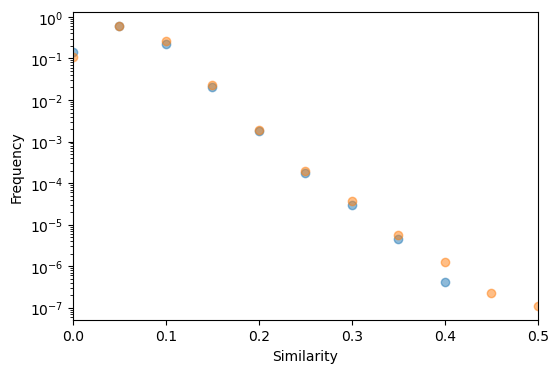

In [74]:
fig, ax = plt.subplots( figsize=(6, 4))
x = np.array(list(hist.keys()))
x_random = np.array(list(hist_random.keys()))
heights = np.array(list(hist.values()))
heights = heights / sum(heights)
heights_random = np.array(list(hist_random.values()))
heights_random = heights_random / sum(heights_random)
ax.scatter(x, heights, alpha=0.5, label="Clustered")
ax.scatter(x_random, heights_random, alpha=0.5, label="Random")
ax.set_yscale("log")
ax.set_xlabel("Similarity")
ax.set_ylabel("Frequency")
ax.set_xlim(0,0.5)
plt.show()

So, pretty similar distribution overall, however, the cluster split immediately cuts at maximum 0.4 similarity, whereas the random split has a fat tail.

In [75]:
training_ids = np.asarray(selected_training_ids)
test_ids = np.asarray(test_ids)
all_ids = np.asarray(ids) # this is needed since a few molecules are not converted to rdkit mols
training_ids_original = all_ids[training_ids]
test_ids_original = all_ids[test_ids]

In [76]:
training_atoms = [all_qm9[i] for i in training_ids_original]
test_atoms = [all_qm9[i] for i in test_ids_original]

In [77]:
aio.write("/home/re344/rds/hpc-work/data/qm9_training_set.xyz", training_atoms, format="extxyz")
aio.write("/home/re344/rds/hpc-work/data/qm9_test_set.xyz", test_atoms, format="extxyz")

/home/re344/.conda/envs/genesis/lib/python3.10/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '
